In [11]:
URL="https://www.cse-cst.gc.ca/en/corporate-information/mandate"

In [4]:
pip install pypdf


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Setup

In [7]:
# Model
from langchain.chat_models import init_chat_model
llm = init_chat_model("gpt-4o-mini", model_provider="openai")
# Embedding
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
# Vector Store
from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embeddings)

In [1]:
from pathlib import Path

# Define root folder path
root_path = Path("./app/static/input")

# List of file or folder names
file_names = ["Communications Security Establishment 101.pdf",
       "CSE Mandates Overview.pdf"
       ]

# Append each file name to the root path
full_paths = [root_path / file_name for file_name in file_names]

# Print full paths
for path in full_paths:
    print(path)


app/static/input/Communications Security Establishment 101.pdf
app/static/input/CSE Mandates Overview.pdf


In [4]:
from pathlib import Path
from langchain.document_loaders import PyPDFLoader

# Set the directory containing PDFs
pdf_dir = Path("./app/static/input")

# Get all PDF files in the directory
pdf_files = list(pdf_dir.glob("*.pdf"))

# Load documents using PyPDFLoader
docs = []
for pdf_file in pdf_files:
    loader = PyPDFLoader(str(pdf_file))  # PyPDFLoader expects a string path
    pages = loader.load()
    docs.extend(pages)  # each PDF returns a list of Document objects

# Now `documents` contains all the parsed pages from all PDFs
print(f"Imported {len(docs)} pages from {len(pdf_files)} PDF files.")


Imported 54 pages from 3 PDF files.


In [13]:
files=["Communications Security Establishment 101.pdf",
       "CSE Mandates Overview.pdf"
       ]

from langchain_community.document_loaders import PyPDFLoader

file_path = "./app/static/input/CSE Mandates Overview.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

1


In [3]:
print(docs[0].page_content[:500])

Communications Security Establishment 101
On this Page
Who We Are...
CSE is Canada's foreign signals intelligence agency, and technical authority for cyber
security and information assurance.
CSE includes the Canadian Centre for Cyber Security (the Cyber Centre), which is the
federal government's operational lead for cyber security.
CSE's mandate has 5 aspects:
Foreign signals intelligence;
Cyber security;
Active cyber operations;
Defensive cyber operations;
Technical and operational assistance 


In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 211 sub-documents.


In [8]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['ea7a70c2-346f-46ec-9d24-3d9bab8db645', 'b95d1640-6999-49f2-bc90-746c9c9d1ab6', '38e279c7-8ff9-4004-a3d7-661e3973a4d0']


In [9]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [10]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [11]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [12]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

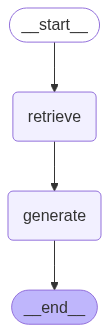

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
result = graph.invoke({"question": "What are the mandates of CSE?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='015d5c48-5f58-442f-82b5-117e705a3f9f', metadata={'producer': 'Skia/PDF m132', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) obsidian/1.8.9 Chrome/132.0.6834.210 Electron/34.3.0 Safari/537.36', 'creationdate': '2025-06-06T19:28:53+00:00', 'title': 'CSE faq - Notes - Obsidian v1.8.10', 'moddate': '2025-06-06T19:28:53+00:00', 'source': 'app/static/input/Communications Security Establishment 101.pdf', 'total_pages': 18, 'page': 6, 'page_label': '7', 'start_index': 0}, page_content="Caption\nCSE's mandate as it is presented in the CSE Act. The mandate is divided into 5 parts.\nOversight\nForeign Signals Intelligence\nCSE's ability to collect Foreign Signals Intelligence through the use of advanced\ntechniques.\nAcquire information from or through the Global Information Infrastructure (GII)\nlocated outside Canada including by engaging or interacting foreign entities\nlocated outside Canada.\nTechnical and operationa